In [245]:
import pandas as pd
import numpy as np
import yfinance as yf
import pickle
import random
import sys
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.service_account import ServiceAccountCredentials

# General Backtest Class

In [246]:
class Bid:
    def __init__(self,ticker,price,shares,bid_type):
        self.ticker = ticker
        self.price = price
        self.shares = shares
        self.bid_type = bid_type
    
    def show(self):
        print("Ticker: {}".format(self.ticker))
        print("Shares: {}".format(self.shares))
        print("price: {}".format(self.price))

class Position:
    def __init__(self,bid):
        self.ticker = bid.ticker
        self.shares = bid.shares
        self.price = bid.price
        
        #k，v: price, number of shares purchased at that price
        self.cost = {}
        self.update_cost(bid)
    
    def change_position(self,bid):
        if bid.bid_type == 1:
            self.shares += bid.shares
            self.update_cost(bid)
        
        if bid.bid_type == 0:
            self.shares -= bid.shares
            return self.update_cost(bid)
        
   
    def update_cost(self,bid):
        #buy
        if bid.bid_type == 1:
            #if have purchased at this price
            if bid.price in self.cost.keys():
                self.cost[bid.price] += bid.shares
            else:
                self.cost[bid.price] = bid.shares
            
                
        #sell
        else:
            
            #if empty position
            if bid.shares == self.shares:
                #weighted average
                return sum([i*j for i,j in zip(self.cost.keys(),self.cost.values())])
            else:
                shares_left = bid.shares
                temp_cost = 0
                for price in sorted(self.cost.keys()):
                    if shares_left > self.cost[price]:
                        shares_left -= self.cost[price]
                        temp_cost += price * self.cost[price]
                        del self.cost[price]
                    else:
                        self.cost[price] -= shares_left
                        temp_cost += price * shares_left
                return temp_cost
                    
  
    def show(self):
        print("Ticker: {}".format(self.ticker))
        print("Shares: {}".format(self.shares))
        print("price: {}".format(self.price))

In [252]:
class Backtest:
    def __init__(self,price_data,initial_amount,strategy, has_tc = True, is_print = False):
        if self.check_input_data(price_data) == True:
            self.df = price_data
        else:
            return
        
        #k,v : String of ticker, a Position type instance
        self.positions = {}
        
        
        self.cash = initial_amount
        self.values = []
        self.strategy = strategy
        
        if has_tc == True:
            self.tc = 0.002
        else:
            self.tc = 0
        
        self.transaction_history = pd.DataFrame(columns = ["dt","ticker","type","price","shares","amount","cash_left","transaction_cost","pnl"])
        self.portfolio_tracker = pd.DataFrame(columns = ["dt","bid_count","position_count","cash_value","positions_value","total_value"])
        
        self.is_print = is_print
    
    def check_input_data(self,df):
        if df.index.inferred_type != "datetime64":
            print("input dataframe must have a datetime64 index")
            return False
        if df.isnull().values.any():
            print("input dataframe contains null values")
            return False
        return True
    
    def update_positions(self,ti):
        current_price = self.df.loc[ti]
        for position in list(self.positions.values()):
            position.price = current_price[position.ticker]
        
        total_position_value = sum([pos.price*pos.shares for pos in self.positions.values()])
        self.values.append(total_position_value+self.cash)
    
    def show_status(self):
        print("cash: {}".format(self.cash))
        print("# of positions: {}".format(len(self.positions)))
        
        for pos in self.positions.values():
            pos.show()
        total_position_value = sum([pos.price*pos.shares for pos in self.positions.values()])
        print("total_position_value: {}".format(total_position_value))
    
    def record_transaction(self,ti,bid,pnl):
        record = [ti,bid.ticker,bid.bid_type,bid.price,bid.shares,bid.price*bid.shares,self.cash,bid.price*bid.shares*self.tc,pnl]
        self.transaction_history.loc[len(self.transaction_history)] = record
        
    def update_tracker(self,ti,bid_list,positions,cash):
        positions_value = sum([pos.price*pos.shares for pos in self.positions.values()])
        record = [ti,len(bid_list),len(positions),cash,positions_value,positions_value+cash]
        self.portfolio_tracker.loc[len(self.portfolio_tracker)] = record
    
    def upload_to_dashboard(self,name):
        if len(self.portfolio_tracker) != len(self.df):
            print("Unable to upload: Backtest is unfinished.")
            return
        if "algo-trade-dashboard-80cae071e907.json" not in os.listdir():
            print("Unable to upload: Couldn't find credential file (algo-trade-dashboard-80cae071e907.json)")
            return
        
        
        self.portfolio_tracker.to_csv(name+".csv")
        


        gauth = GoogleAuth()
        scope = ['https://www.googleapis.com/auth/drive.file',
            'https://www.googleapis.com/auth/drive',
            'https://www.googleapis.com/auth/drive.file',
            'https://www.googleapis.com/auth/drive.metadata'
          ]

        gauth.credentials = ServiceAccountCredentials.from_json_keyfile_name("algo-trade-dashboard-80cae071e907.json", scope)
        drive = GoogleDrive(gauth)

        f1 = drive.CreateFile({'name':name+"_backtest_result.csv"})

        f1.SetContentFile(name+".csv")
        f1.Upload()

        print("Data uploaded.")
        
    
    def backtest(self):
    
        for ti in self.df.index:
            
            if self.is_print == True:
                print("=====================================================================")
                print(ti)
            self.update_positions(ti)
            
            #self.show_status()
            
            
            
            #where the strategy kick in and gives a list of bids
            bid_list = self.strategy(ti,self.df.loc[:ti],self.positions,self.cash)
            
            
            
            #process the bids
            for bid in bid_list:
                #if already have a positionn
                if bid.ticker in self.positions.keys():
                    pos = self.positions[bid.ticker]
                    
                    #if increase position
                    if bid.bid_type == 1:
                        cost = bid.shares * bid.price
                        if self.cash < cost * (1+self.tc):
                            print("Not enough cash to build a position for "+bid.ticker)
                            continue
                        
                        #update cash
                        self.cash -= cost * (1+self.tc)
                        
                        #update position
                        pos.change_position(bid)
                        self.record_transaction(ti,bid,0)
                    
                    #if decrease position
                    else:
                        income = bid.shares * bid.price
                        if self.positions[bid.ticker].shares < bid.shares:
                            print("Try to sell {} shares, but only got {} shares.".format(bid.shares,self.positions[bid.ticker].shares))
                            continue
                        
                        #update cash
                        self.cash += income
                        self.cash -= income*self.tc
                        
                        #update position,and get a cost

                        temp_cost = pos.change_position(bid)
                       
                        #calculate pnl
                        pnl = income-temp_cost
                        
                        #record this transaction
                        self.record_transaction(ti,bid,pnl)
                        if pos.shares == 0:
                            del pos
                            del self.positions[bid.ticker]
                    
                    
                
                #if not have a position yet
                else:
                    cost = bid.shares * bid.price
                    if self.cash < cost * (1+self.tc):
                        print("Not enough cash to build a position for "+bid.ticker)
                        continue

                    #update cash
                    self.cash -= cost * (1+self.tc)

                    #build position
                    self.positions[bid.ticker] = Position(bid)
                    
                    #record this transaction
                    self.record_transaction(ti,bid,0)
            
            self.update_tracker(ti,bid_list,self.positions,self.cash)

- ti: current datetime
- df: all price data up to current ti
- positions: dictionary of all current positions
- cash: current cash


In [248]:
def my_strategy(ti,df,positions,cash):
    res = []
    prices = df.iloc[-1]
    if ti.day % 3 == 0:
        ticker = random.choice(list(df.columns))
        bid = Bid(ticker = ticker,shares = 100,price = prices[ticker],bid_type = 1)
        res.append(bid)
    
    if ti.day % 5 == 0 and len(list(positions.keys())) > 0:
        ticker = random.choice(list(positions.keys()))
        bid = Bid(ticker = ticker,shares = positions[ticker].shares,price = prices[ticker],bid_type = 0)

    return res

In [249]:
data = pd.read_csv("sample_data.csv",index_col = 0)
data.index = pd.to_datetime(data.index)
bt = Backtest(data.dropna(axis = 0),100000,BAH)
bt.backtest()

In [250]:
bt.upload_to_dashboard("demo")

Data uploaded.


## A BAH strategy

In [193]:
def BAH(ti,df,positions,cash):
    res = []
    if ti == df.index[0]:
        
        count = len(df.columns)
        weight = cash//count
        
        #Latest price
        prices = df.iloc[-1]
        for ticker in df.columns:
            price = prices[ticker]
            bid = Bid(ticker = ticker, shares = weight//price,price = price, bid_type = 1)
            res.append(bid)
    return res

In [194]:
bt = Backtest(data.dropna(axis = 0),100000,BAH)
bt.backtest()

2019-09-10 00:00:00
2019-09-11 00:00:00
2019-09-12 00:00:00
2019-09-13 00:00:00
2019-09-16 00:00:00
2019-09-17 00:00:00
2019-09-18 00:00:00
2019-09-19 00:00:00
2019-09-20 00:00:00
2019-09-23 00:00:00
2019-09-24 00:00:00
2019-09-25 00:00:00
2019-09-26 00:00:00
2019-09-27 00:00:00
2019-09-30 00:00:00
2019-10-01 00:00:00
2019-10-02 00:00:00
2019-10-03 00:00:00
2019-10-04 00:00:00
2019-10-07 00:00:00
2019-10-08 00:00:00
2019-10-09 00:00:00
2019-10-10 00:00:00
2019-10-11 00:00:00
2019-10-14 00:00:00
2019-10-15 00:00:00
2019-10-16 00:00:00
2019-10-17 00:00:00
2019-10-18 00:00:00
2019-10-21 00:00:00
2019-10-22 00:00:00
2019-10-23 00:00:00
2019-10-24 00:00:00
2019-10-25 00:00:00
2019-10-28 00:00:00
2019-10-29 00:00:00
2019-10-30 00:00:00
2019-10-31 00:00:00
2019-11-01 00:00:00
2019-11-04 00:00:00
2019-11-05 00:00:00
2019-11-06 00:00:00
2019-11-07 00:00:00
2019-11-08 00:00:00
2019-11-11 00:00:00
2019-11-12 00:00:00
2019-11-13 00:00:00
2019-11-14 00:00:00
2019-11-15 00:00:00
2019-11-18 00:00:00


2020-08-12 00:00:00
2020-08-13 00:00:00
2020-08-14 00:00:00
2020-08-17 00:00:00
2020-08-18 00:00:00
2020-08-19 00:00:00
2020-08-20 00:00:00
2020-08-21 00:00:00
2020-08-24 00:00:00
2020-08-25 00:00:00
2020-08-26 00:00:00
2020-08-27 00:00:00
2020-08-28 00:00:00
2020-08-31 00:00:00
2020-09-01 00:00:00
2020-09-02 00:00:00
2020-09-03 00:00:00
2020-09-04 00:00:00
2020-09-08 00:00:00
2020-09-09 00:00:00
2020-09-10 00:00:00
2020-09-11 00:00:00
2020-09-14 00:00:00
2020-09-15 00:00:00
2020-09-16 00:00:00
2020-09-17 00:00:00
2020-09-18 00:00:00
2020-09-21 00:00:00
2020-09-22 00:00:00
2020-09-23 00:00:00
2020-09-24 00:00:00
2020-09-25 00:00:00
2020-09-28 00:00:00
2020-09-29 00:00:00
2020-09-30 00:00:00
2020-10-01 00:00:00
2020-10-02 00:00:00
2020-10-05 00:00:00
2020-10-06 00:00:00
2020-10-07 00:00:00
2020-10-08 00:00:00
2020-10-09 00:00:00
2020-10-12 00:00:00
2020-10-13 00:00:00
2020-10-14 00:00:00
2020-10-15 00:00:00
2020-10-16 00:00:00
2020-10-19 00:00:00
2020-10-20 00:00:00
2020-10-21 00:00:00


2021-07-07 00:00:00
2021-07-08 00:00:00
2021-07-09 00:00:00
2021-07-12 00:00:00
2021-07-13 00:00:00
2021-07-14 00:00:00
2021-07-15 00:00:00
2021-07-16 00:00:00
2021-07-19 00:00:00
2021-07-20 00:00:00
2021-07-21 00:00:00
2021-07-22 00:00:00
2021-07-23 00:00:00
2021-07-26 00:00:00
2021-07-27 00:00:00
2021-07-28 00:00:00
2021-07-29 00:00:00
2021-07-30 00:00:00
2021-08-02 00:00:00
2021-08-03 00:00:00
2021-08-04 00:00:00
2021-08-05 00:00:00
2021-08-06 00:00:00
2021-08-09 00:00:00
2021-08-10 00:00:00
2021-08-11 00:00:00
2021-08-12 00:00:00
2021-08-13 00:00:00
2021-08-16 00:00:00
2021-08-17 00:00:00
2021-08-18 00:00:00
2021-08-19 00:00:00
2021-08-20 00:00:00
2021-08-23 00:00:00
2021-08-24 00:00:00
2021-08-25 00:00:00
2021-08-26 00:00:00
2021-08-27 00:00:00
2021-08-30 00:00:00
2021-08-31 00:00:00
2021-09-01 00:00:00
2021-09-02 00:00:00
2021-09-03 00:00:00
2021-09-07 00:00:00
2021-09-08 00:00:00
2021-09-09 00:00:00
2021-09-10 00:00:00
2021-09-13 00:00:00
2021-09-14 00:00:00
2021-09-15 00:00:00


2022-04-29 00:00:00
2022-05-02 00:00:00
2022-05-03 00:00:00
2022-05-04 00:00:00
2022-05-05 00:00:00
2022-05-06 00:00:00
2022-05-09 00:00:00
2022-05-10 00:00:00
2022-05-11 00:00:00
2022-05-12 00:00:00
2022-05-13 00:00:00
2022-05-16 00:00:00
2022-05-17 00:00:00
2022-05-18 00:00:00
2022-05-19 00:00:00
2022-05-20 00:00:00
2022-05-23 00:00:00
2022-05-24 00:00:00
2022-05-25 00:00:00
2022-05-26 00:00:00
2022-05-27 00:00:00
2022-05-31 00:00:00
2022-06-01 00:00:00
2022-06-02 00:00:00
2022-06-03 00:00:00
2022-06-06 00:00:00
2022-06-07 00:00:00
2022-06-08 00:00:00
2022-06-09 00:00:00
2022-06-10 00:00:00
2022-06-13 00:00:00
2022-06-14 00:00:00
2022-06-15 00:00:00
2022-06-16 00:00:00
2022-06-17 00:00:00
2022-06-21 00:00:00
2022-06-22 00:00:00
2022-06-23 00:00:00
2022-06-24 00:00:00
2022-06-27 00:00:00
2022-06-28 00:00:00
2022-06-29 00:00:00
2022-06-30 00:00:00
2022-07-01 00:00:00
2022-07-05 00:00:00
2022-07-06 00:00:00
2022-07-07 00:00:00
2022-07-08 00:00:00
2022-07-11 00:00:00
2022-07-12 00:00:00


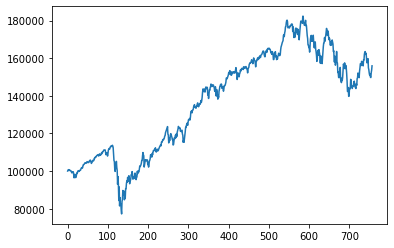

In [196]:
plt.plot(bt.values)

In [195]:
bt.transaction_history

,dt,ticker,type,price,shares,amount,cash_left,transaction_cost,pnl
0,2019-09-10,AAPL,1,53.002941,18.0,954.052940,99044.038954,1.908106,0
1,2019-09-10,ABBV,1,59.077267,16.0,945.236267,98096.912214,1.890473,0
2,2019-09-10,ABT,1,79.396255,12.0,952.755066,97142.251638,1.905510,0
3,2019-09-10,ACN,1,181.930023,5.0,909.650116,96230.782222,1.819300,0
4,2019-09-10,ADBE,1,276.140015,3.0,828.420044,95400.705338,1.656840,0
...,...,...,...,...,...,...,...,...,...
95,2019-09-10,VZ,1,52.218174,19.0,992.145306,11131.712377,1.984291,0
96,2019-09-10,WBA,1,50.365017,19.0,956.935322,10172.863185,1.913871,0
97,2019-09-10,WFC,1,44.628483,22.0,981.826622,9189.072909,1.963653,0
98,2019-09-10,WMT,1,110.540100,9.0,994.860901,8192.222287,1.989722,0


# Demo
## sp100 data for 15 day with 15min interval 
## input data must have a datetime index and must not contain null values

In [167]:
data = pd.read_csv("sample_data.csv",index_col = 0)
data.index = pd.to_datetime(data.index)

In [168]:
bt = Backtest(data.dropna(axis = 0),100000,my_strategy)

In [169]:
bt.backtest()

2019-09-10 00:00:00
cash: 100000
# of positions: 0
total_position_value: 0
2019-09-11 00:00:00
cash: 100000
# of positions: 0
total_position_value: 0
2019-09-12 00:00:00
cash: 100000
# of positions: 0
total_position_value: 0
2019-09-13 00:00:00
cash: 99872.51794852447
# of positions: 1
Ticker: BK
Shares: 3
price: 42.94950485229492
total_position_value: 128.84851455688477
2019-09-16 00:00:00
cash: 99872.51794852447
# of positions: 1
Ticker: BK
Shares: 3
price: 42.8121337890625
total_position_value: 128.4364013671875
2019-09-17 00:00:00
cash: 99872.51794852447
# of positions: 1
Ticker: BK
Shares: 3
price: 42.4458236694336
total_position_value: 127.33747100830081
2019-09-18 00:00:00
cash: 99872.51794852447
# of positions: 1
Ticker: BK
Shares: 3
price: 43.04108047485352
total_position_value: 129.12324142456058
2019-09-19 00:00:00
cash: 99736.64305386352
# of positions: 2
Ticker: BK
Shares: 3
price: 43.02275466918945
Ticker: WFC
Shares: 3
price: 45.1827507019043
total_position_value: 264.61

Shares: 3
price: 158.58999633789062
total_position_value: 3133.704116821289
2019-12-13 00:00:00
cash: 96679.4517323837
# of positions: 9
Ticker: DOW
Shares: 3
price: 46.24691390991211
Ticker: MMM
Shares: 3
price: 153.08033752441406
Ticker: JNJ
Shares: 3
price: 131.66207885742188
Ticker: ABT
Shares: 3
price: 82.72264862060547
Ticker: COP
Shares: 3
price: 56.884239196777344
Ticker: MA
Shares: 3
price: 291.8276672363281
Ticker: JPM
Shares: 3
price: 125.95843505859376
Ticker: CRM
Shares: 3
price: 161.1300048828125
Ticker: LOW
Shares: 3
price: 113.31055450439452
total_position_value: 3488.4686393737793
2019-12-16 00:00:00
cash: 96679.4517323837
# of positions: 9
Ticker: DOW
Shares: 3
price: 47.01943588256836
Ticker: MMM
Shares: 3
price: 154.85789489746094
Ticker: JNJ
Shares: 3
price: 132.04383850097656
Ticker: ABT
Shares: 3
price: 82.77055358886719
Ticker: COP
Shares: 3
price: 56.99311828613281
Ticker: MA
Shares: 3
price: 292.68511962890625
Ticker: JPM
Shares: 3
price: 126.4463882446289
Tic

price: 86.14297485351562
Ticker: COP
Shares: 3
price: 55.5052375793457
Ticker: LOW
Shares: 3
price: 116.36756896972656
Ticker: SBUX
Shares: 6
price: 83.89482879638672
Ticker: BK
Shares: 3
price: 41.73493194580078
Ticker: DD
Shares: 3
price: 54.9370002746582
Ticker: NKE
Shares: 3
price: 97.9702377319336
Ticker: SPG
Shares: 3
price: 119.53466033935548
Ticker: MCD
Shares: 3
price: 197.3835906982422
Ticker: SCHW
Shares: 3
price: 44.61814880371094
Ticker: GD
Shares: 3
price: 171.92068481445312
total_position_value: 4260.619068145752
2020-01-29 00:00:00
cash: 95974.06185980223
# of positions: 13
Ticker: DOW
Shares: 3
price: 43.11344909667969
Ticker: JNJ
Shares: 3
price: 140.19239807128906
Ticker: ABT
Shares: 6
price: 85.75814819335938
Ticker: COP
Shares: 3
price: 54.87923812866211
Ticker: LOW
Shares: 3
price: 115.66637420654295
Ticker: SBUX
Shares: 6
price: 82.11466979980469
Ticker: BK
Shares: 3
price: 41.26162338256836
Ticker: DD
Shares: 3
price: 54.6999626159668
Ticker: NKE
Shares: 3
price

Shares: 6
price: 131.2270050048828
Ticker: ABT
Shares: 6
price: 78.51383972167969
Ticker: COP
Shares: 3
price: 44.97978591918945
Ticker: SBUX
Shares: 6
price: 78.36869049072266
Ticker: BK
Shares: 3
price: 38.01341247558594
Ticker: SCHW
Shares: 3
price: 40.6080322265625
Ticker: GD
Shares: 3
price: 154.5067138671875
Ticker: TXN
Shares: 3
price: 111.48336029052734
Ticker: JPM
Shares: 3
price: 112.59947204589844
Ticker: MO
Shares: 3
price: 34.54674530029297
Ticker: BAC
Shares: 6
price: 27.58445167541504
Ticker: VZ
Shares: 3
price: 51.176753997802734
total_position_value: 3767.54691696167
2020-03-03 00:00:00
cash: 96132.1703731079
# of positions: 13
Ticker: DOW
Shares: 3
price: 35.78791046142578
Ticker: JNJ
Shares: 6
price: 127.07521057128906
Ticker: ABT
Shares: 6
price: 75.03115844726562
Ticker: COP
Shares: 3
price: 43.96561050415039
Ticker: SBUX
Shares: 6
price: 74.77275848388672
Ticker: BK
Shares: 3
price: 36.0366439819336
Ticker: SCHW
Shares: 3
price: 37.04829406738281
Ticker: GD
Shares

Shares: 3
price: 48.90005111694336
Ticker: GS
Shares: 3
price: 151.13681030273438
Ticker: DD
Shares: 3
price: 32.08113479614258
Ticker: CVS
Shares: 3
price: 55.8739128112793
Ticker: MSFT
Shares: 3
price: 156.638427734375
Ticker: DUK
Shares: 3
price: 75.5114974975586
Ticker: RTX
Shares: 3
price: 58.09603500366211
total_position_value: 3847.2048568725586
2020-03-31 00:00:00
cash: 95071.82253033065
# of positions: 16
Ticker: DOW
Shares: 3
price: 25.79976272583008
Ticker: ABT
Shares: 6
price: 75.91627502441406
Ticker: SBUX
Shares: 6
price: 62.53894805908203
Ticker: BK
Shares: 3
price: 31.25711250305176
Ticker: GD
Shares: 3
price: 123.87311553955078
Ticker: TXN
Shares: 3
price: 93.6415023803711
Ticker: JPM
Shares: 3
price: 83.42109680175781
Ticker: MO
Shares: 3
price: 32.628170013427734
Ticker: VZ
Shares: 3
price: 47.97150802612305
Ticker: GS
Shares: 3
price: 146.37416076660156
Ticker: DD
Shares: 3
price: 32.53916549682617
Ticker: CVS
Shares: 3
price: 55.546234130859375
Ticker: MSFT
Shares:

Shares: 3
price: 105.33768463134766
Ticker: JPM
Shares: 3
price: 86.13229370117188
Ticker: MO
Shares: 3
price: 31.05034065246582
Ticker: VZ
Shares: 3
price: 50.99617385864258
Ticker: GS
Shares: 3
price: 168.8240966796875
Ticker: DD
Shares: 3
price: 42.64444351196289
Ticker: CVS
Shares: 3
price: 57.78588485717773
Ticker: MSFT
Shares: 3
price: 176.70828247070312
Ticker: DUK
Shares: 3
price: 75.22197723388672
Ticker: RTX
Shares: 3
price: 55.30064392089844
Ticker: UNP
Shares: 3
price: 148.6524200439453
Ticker: UPS
Shares: 3
price: 86.66727447509766
Ticker: AMZN
Shares: 3
price: 115.88999938964844
Ticker: AMGN
Shares: 3
price: 219.3050079345703
Ticker: LMT
Shares: 3
price: 364.416015625
Ticker: ADBE
Shares: 3
price: 356.1300048828125
Ticker: MET
Shares: 3
price: 31.23130226135254
total_position_value: 7778.9908447265625
2020-05-06 00:00:00
cash: 92471.09372645569
# of positions: 19
Ticker: ABT
Shares: 6
price: 87.9935302734375
Ticker: SBUX
Shares: 9
price: 69.40740203857422
Ticker: BK
Share

Ticker: SBUX
Shares: 9
price: 75.13792419433594
Ticker: BK
Shares: 3
price: 35.19090270996094
Ticker: TXN
Shares: 6
price: 109.42691040039062
Ticker: JPM
Shares: 3
price: 93.4909896850586
Ticker: MO
Shares: 3
price: 32.746299743652344
Ticker: VZ
Shares: 3
price: 50.28325653076172
Ticker: GS
Shares: 3
price: 190.52598571777344
Ticker: DD
Shares: 3
price: 48.48257064819336
Ticker: DUK
Shares: 3
price: 78.56238555908203
Ticker: RTX
Shares: 3
price: 63.610618591308594
Ticker: UNP
Shares: 3
price: 162.99363708496094
Ticker: UPS
Shares: 3
price: 94.19806671142578
Ticker: AMZN
Shares: 6
price: 120.05500030517578
Ticker: AMGN
Shares: 3
price: 209.36508178710935
Ticker: LMT
Shares: 3
price: 372.0161743164063
Ticker: ADBE
Shares: 3
price: 379.8299865722656
Ticker: INTC
Shares: 3
price: 57.80999755859375
Ticker: LLY
Shares: 3
price: 145.349365234375
Ticker: MS
Shares: 3
price: 41.69590759277344
Ticker: ORCL
Shares: 3
price: 51.74337387084961
total_position_value: 8910.690330505371
2020-05-29 00:0

price: 154.8045654296875
Ticker: MS
Shares: 3
price: 44.494415283203125
Ticker: CSCO
Shares: 3
price: 42.20851516723633
Ticker: PG
Shares: 3
price: 111.54684448242188
Ticker: COP
Shares: 3
price: 40.1972885131836
Ticker: CL
Shares: 3
price: 69.44300079345703
total_position_value: 8134.219539642334
2020-06-23 00:00:00
cash: 92208.76414114762
# of positions: 22
Ticker: ABT
Shares: 6
price: 88.20608520507812
Ticker: SBUX
Shares: 9
price: 72.22003936767578
Ticker: BK
Shares: 3
price: 36.2487907409668
Ticker: TXN
Shares: 6
price: 119.5791473388672
Ticker: JPM
Shares: 3
price: 91.68408203125
Ticker: MO
Shares: 3
price: 34.780845642089844
Ticker: VZ
Shares: 3
price: 49.57936096191406
Ticker: GS
Shares: 3
price: 195.10877990722656
Ticker: DD
Shares: 3
price: 50.79630279541016
Ticker: DUK
Shares: 3
price: 74.91938781738281
Ticker: RTX
Shares: 3
price: 61.02912902832031
Ticker: UNP
Shares: 3
price: 161.89434814453125
Ticker: UPS
Shares: 3
price: 104.48504638671876
Ticker: AMZN
Shares: 6
price: 1

Ticker: MO
Shares: 3
price: 34.668758392333984
Ticker: VZ
Shares: 3
price: 49.6889762878418
Ticker: GS
Shares: 3
price: 199.0151824951172
Ticker: DD
Shares: 3
price: 50.42187881469727
Ticker: DUK
Shares: 3
price: 74.52578735351562
Ticker: UPS
Shares: 3
price: 107.46062469482422
Ticker: AMZN
Shares: 6
price: 155.1999969482422
Ticker: ADBE
Shares: 3
price: 442.4700012207031
Ticker: INTC
Shares: 3
price: 54.88671112060547
Ticker: LLY
Shares: 3
price: 156.37721252441406
Ticker: MS
Shares: 3
price: 47.16144943237305
Ticker: CSCO
Shares: 3
price: 43.266361236572266
Ticker: COP
Shares: 3
price: 36.59835052490234
Ticker: CL
Shares: 3
price: 69.78499603271484
Ticker: META
Shares: 3
price: 239.0
Ticker: FDX
Shares: 3
price: 151.61703491210938
Ticker: AMGN
Shares: 3
price: 233.56820678710935
Ticker: V
Shares: 3
price: 186.3095245361328
total_position_value: 9742.82213973999
2020-07-14 00:00:00
cash: 90793.1990824623
# of positions: 23
Ticker: ABT
Shares: 6
price: 91.9624252319336
Ticker: SBUX
Sha

Shares: 6
price: 35.824100494384766
Ticker: VZ
Shares: 3
price: 52.773433685302734
Ticker: GS
Shares: 6
price: 194.60382080078125
Ticker: DD
Shares: 3
price: 52.80974960327149
Ticker: DUK
Shares: 6
price: 77.07955169677734
Ticker: UPS
Shares: 3
price: 137.41468811035156
Ticker: ADBE
Shares: 3
price: 464.1099853515625
Ticker: INTC
Shares: 3
price: 45.81687545776367
Ticker: LLY
Shares: 3
price: 147.5009002685547
Ticker: CSCO
Shares: 3
price: 44.999656677246094
Ticker: CL
Shares: 3
price: 72.49031066894531
Ticker: META
Shares: 3
price: 265.2799987792969
Ticker: FDX
Shares: 3
price: 167.15431213378906
Ticker: AMGN
Shares: 3
price: 225.63751220703125
Ticker: V
Shares: 3
price: 195.91970825195312
Ticker: PG
Shares: 3
price: 126.5120849609375
Ticker: BA
Shares: 3
price: 172.1999969482422
Ticker: EXC
Shares: 3
price: 25.06974601745605
total_position_value: 10718.012929916382
2020-08-07 00:00:00
cash: 90068.18237207034
# of positions: 23
Ticker: ABT
Shares: 6
price: 98.17926025390624
Ticker: SB

Ticker: EXC
Shares: 3
price: 24.91274070739746
Ticker: KHC
Shares: 3
price: 30.83221244812012
Ticker: LIN
Shares: 6
price: 243.03204345703125
Ticker: SO
Shares: 3
price: 48.57728576660156
Ticker: IBM
Shares: 3
price: 107.65093231201172
total_position_value: 12058.992050170898
2020-09-04 00:00:00
cash: 89222.44385006715
# of positions: 24
Ticker: ABT
Shares: 6
price: 101.0209503173828
Ticker: SBUX
Shares: 9
price: 82.98204803466797
Ticker: TXN
Shares: 6
price: 133.57220458984375
Ticker: MO
Shares: 6
price: 37.49674987792969
Ticker: VZ
Shares: 3
price: 55.19171905517578
Ticker: GS
Shares: 6
price: 202.1946563720703
Ticker: DD
Shares: 3
price: 56.7576904296875
Ticker: DUK
Shares: 6
price: 74.97191619873047
Ticker: UPS
Shares: 3
price: 152.84446716308594
Ticker: ADBE
Shares: 3
price: 491.9400024414063
Ticker: INTC
Shares: 3
price: 47.24128341674805
Ticker: LLY
Shares: 3
price: 146.30995178222656
Ticker: CSCO
Shares: 6
price: 38.45270919799805
Ticker: CL
Shares: 3
price: 73.78034973144531
T

Shares: 3
price: 67.09783935546875
Ticker: GILD
Shares: 3
price: 57.56926727294922
Ticker: BK
Shares: 3
price: 31.535869598388672
Ticker: SPG
Shares: 3
price: 56.23396301269531
Ticker: BAC
Shares: 3
price: 22.513280868530277
total_position_value: 11793.1981716156
2020-09-28 00:00:00
cash: 90587.07767473221
# of positions: 25
Ticker: ABT
Shares: 6
price: 101.2925262451172
Ticker: SBUX
Shares: 9
price: 82.78966522216797
Ticker: TXN
Shares: 6
price: 134.97003173828125
Ticker: MO
Shares: 6
price: 34.2582893371582
Ticker: GS
Shares: 6
price: 190.8168029785156
Ticker: DD
Shares: 3
price: 54.58583831787109
Ticker: DUK
Shares: 6
price: 76.7311782836914
Ticker: UPS
Shares: 3
price: 160.56369018554688
Ticker: INTC
Shares: 3
price: 48.51476287841797
Ticker: LLY
Shares: 3
price: 143.58560180664062
Ticker: CSCO
Shares: 6
price: 36.86071395874024
Ticker: CL
Shares: 3
price: 73.20701599121094
Ticker: META
Shares: 3
price: 256.82000732421875
Ticker: V
Shares: 3
price: 197.74595642089844
Ticker: PG
Sha

price: 195.15963745117188
Ticker: PG
Shares: 6
price: 135.82579040527344
Ticker: KHC
Shares: 3
price: 29.398584365844727
Ticker: SO
Shares: 3
price: 54.11842346191406
Ticker: IBM
Shares: 3
price: 101.52664184570312
Ticker: COF
Shares: 3
price: 74.74984741210938
Ticker: GILD
Shares: 3
price: 55.9970932006836
Ticker: BK
Shares: 3
price: 35.02936553955078
Ticker: SPG
Shares: 3
price: 58.07518768310547
Ticker: BAC
Shares: 3
price: 23.136249542236328
Ticker: GOOG
Shares: 3
price: 77.79650115966797
Ticker: WMT
Shares: 3
price: 139.47122192382812
Ticker: MS
Shares: 3
price: 48.67205047607422
total_position_value: 10259.962446212769
2020-10-21 00:00:00
cash: 91310.23766359329
# of positions: 24
Ticker: ABT
Shares: 6
price: 103.08003997802734
Ticker: SBUX
Shares: 9
price: 84.90582275390625
Ticker: TXN
Shares: 6
price: 138.95431518554688
Ticker: MO
Shares: 6
price: 33.87129211425781
Ticker: GS
Shares: 6
price: 194.49761962890625
Ticker: DD
Shares: 3
price: 56.62255096435547
Ticker: UPS
Shares: 6

price: 161.10284423828125
Ticker: LLY
Shares: 3
price: 137.00489807128906
Ticker: CSCO
Shares: 9
price: 40.44258117675781
Ticker: CL
Shares: 3
price: 82.56599426269531
Ticker: V
Shares: 3
price: 210.2832489013672
Ticker: PG
Shares: 6
price: 136.5320281982422
Ticker: KHC
Shares: 3
price: 29.545625686645508
Ticker: SO
Shares: 3
price: 59.8189811706543
Ticker: IBM
Shares: 3
price: 103.86761474609376
Ticker: COF
Shares: 3
price: 85.82905578613281
Ticker: GILD
Shares: 3
price: 56.496490478515625
Ticker: SPG
Shares: 3
price: 71.13894653320312
Ticker: BAC
Shares: 3
price: 26.433216094970703
Ticker: GOOG
Shares: 3
price: 89.06900024414062
Ticker: WMT
Shares: 3
price: 147.74839782714844
Ticker: VZ
Shares: 3
price: 56.15749740600586
Ticker: BLK
Shares: 3
price: 646.1446533203125
Ticker: GE
Shares: 3
price: 76.0897445678711
Ticker: F
Shares: 3
price: 8.568096160888672
total_position_value: 12398.74941444397
2020-11-17 00:00:00
cash: 89777.49298335555
# of positions: 25
Ticker: ABT
Shares: 6
price

price: 65.52601623535156
Ticker: UPS
Shares: 9
price: 161.81060791015625
Ticker: LLY
Shares: 3
price: 153.97091674804688
Ticker: CSCO
Shares: 9
price: 42.486572265625
Ticker: V
Shares: 3
price: 207.1986846923828
Ticker: PG
Shares: 6
price: 130.76132202148438
Ticker: KHC
Shares: 3
price: 31.82422637939453
Ticker: SO
Shares: 6
price: 56.69368743896485
Ticker: IBM
Shares: 3
price: 111.26541137695312
Ticker: COF
Shares: 3
price: 91.94102478027344
Ticker: GILD
Shares: 3
price: 56.24679183959961
Ticker: SPG
Shares: 3
price: 81.84222412109375
Ticker: GOOG
Shares: 3
price: 89.20649719238281
Ticker: WMT
Shares: 3
price: 143.7067108154297
Ticker: VZ
Shares: 3
price: 56.68318939208984
Ticker: BLK
Shares: 3
price: 673.6683349609375
Ticker: GE
Shares: 3
price: 90.56031799316406
Ticker: F
Shares: 3
price: 9.200966835021973
Ticker: AMZN
Shares: 3
price: 155.2100067138672
Ticker: CAT
Shares: 3
price: 173.4874267578125
Ticker: DOW
Shares: 3
price: 50.47400665283203
total_position_value: 13749.684645652

price: 132.0650177001953
Ticker: KHC
Shares: 3
price: 32.242713928222656
Ticker: IBM
Shares: 3
price: 109.11540985107422
Ticker: COF
Shares: 3
price: 94.80811309814452
Ticker: GILD
Shares: 3
price: 52.98331451416016
Ticker: SPG
Shares: 3
price: 76.8459701538086
Ticker: GOOG
Shares: 3
price: 86.97599792480469
Ticker: WMT
Shares: 3
price: 140.25340270996094
Ticker: VZ
Shares: 3
price: 53.6212272644043
Ticker: BLK
Shares: 3
price: 680.6386108398438
Ticker: GE
Shares: 3
price: 85.23207092285156
Ticker: F
Shares: 3
price: 8.626514434814453
Ticker: AMZN
Shares: 3
price: 164.29249572753906
Ticker: CAT
Shares: 3
price: 173.45849609375
Ticker: DOW
Shares: 3
price: 51.22196960449219
Ticker: AMT
Shares: 3
price: 213.6509552001953
Ticker: XOM
Shares: 3
price: 37.99824905395508
Ticker: EXC
Shares: 3
price: 28.26616859436035
Ticker: CHTR
Shares: 3
price: 653.489990234375
total_position_value: 15063.712972640991
2020-12-31 00:00:00
cash: 87187.85529670242
# of positions: 28
Ticker: ABT
Shares: 6
pric

Shares: 3
price: 102.03401184082033
Ticker: SPG
Shares: 3
price: 87.38861083984375
Ticker: GOOG
Shares: 3
price: 95.05249786376952
Ticker: WMT
Shares: 3
price: 142.3448486328125
Ticker: VZ
Shares: 3
price: 53.57072448730469
Ticker: BLK
Shares: 3
price: 705.706298828125
Ticker: GE
Shares: 3
price: 88.41533660888672
Ticker: F
Shares: 3
price: 11.21641731262207
Ticker: AMZN
Shares: 3
price: 164.6114959716797
Ticker: CAT
Shares: 3
price: 185.90737915039065
Ticker: AMT
Shares: 3
price: 217.1222686767578
Ticker: XOM
Shares: 3
price: 43.323486328125
Ticker: EXC
Shares: 3
price: 28.677387237548828
Ticker: CHTR
Shares: 3
price: 646.6900024414062
Ticker: UPS
Shares: 3
price: 152.06448364257812
Ticker: QCOM
Shares: 3
price: 157.10476684570312
Ticker: LMT
Shares: 3
price: 323.4581604003906
total_position_value: 16170.853729248047
2021-01-25 00:00:00
cash: 87041.85595852189
# of positions: 28
Ticker: ABT
Shares: 6
price: 112.08328247070312
Ticker: SBUX
Shares: 9
price: 99.97650909423828
Ticker: MO


Ticker: AMGN
Shares: 3
price: 224.1830902099609
total_position_value: 17226.836923599243
2021-02-12 00:00:00
cash: 86156.79957238298
# of positions: 28
Ticker: ABT
Shares: 6
price: 125.2827606201172
Ticker: SBUX
Shares: 9
price: 101.76439666748048
Ticker: MO
Shares: 9
price: 38.95370864868164
Ticker: GS
Shares: 6
price: 295.2208251953125
Ticker: DD
Shares: 3
price: 69.30805206298828
Ticker: LLY
Shares: 3
price: 202.8475646972656
Ticker: CSCO
Shares: 9
price: 45.32299041748047
Ticker: V
Shares: 3
price: 207.8966522216797
Ticker: PG
Shares: 6
price: 123.0732192993164
Ticker: KHC
Shares: 3
price: 32.91231155395508
Ticker: IBM
Shares: 3
price: 107.4254379272461
Ticker: SPG
Shares: 3
price: 99.99036407470705
Ticker: GOOG
Shares: 3
price: 105.20549774169922
Ticker: WMT
Shares: 3
price: 140.53550720214844
Ticker: VZ
Shares: 3
price: 50.522586822509766
Ticker: BLK
Shares: 3
price: 694.1181640625
Ticker: GE
Shares: 3
price: 93.3494110107422
Ticker: F
Shares: 3
price: 11.14826202392578
Ticker: A

Ticker: V
Shares: 3
price: 209.4215240478516
Ticker: PG
Shares: 6
price: 117.79810333251952
Ticker: KHC
Shares: 3
price: 34.60489273071289
Ticker: IBM
Shares: 3
price: 106.81183624267578
Ticker: SPG
Shares: 3
price: 100.76824188232422
Ticker: GOOG
Shares: 3
price: 102.45449829101562
Ticker: WMT
Shares: 3
price: 124.05684661865234
Ticker: VZ
Shares: 3
price: 51.081878662109375
Ticker: BLK
Shares: 3
price: 659.8203735351562
Ticker: GE
Shares: 3
price: 107.9924545288086
Ticker: F
Shares: 3
price: 11.615612030029297
Ticker: AMZN
Shares: 3
price: 148.8784942626953
Ticker: XOM
Shares: 3
price: 54.537559509277344
Ticker: EXC
Shares: 3
price: 26.81005477905273
Ticker: CHTR
Shares: 3
price: 607.6400146484375
Ticker: UPS
Shares: 3
price: 153.46998596191406
Ticker: QCOM
Shares: 3
price: 124.20684051513672
Ticker: LMT
Shares: 3
price: 324.37518310546875
Ticker: GOOGL
Shares: 3
price: 101.69650268554688
Ticker: TMO
Shares: 3
price: 440.0714416503906
Ticker: AMGN
Shares: 3
price: 211.6595916748047
T

2021-03-25 00:00:00
cash: 84205.36838547808
# of positions: 30
Ticker: ABT
Shares: 6
price: 116.3137664794922
Ticker: SBUX
Shares: 12
price: 104.18724060058594
Ticker: MO
Shares: 9
price: 45.8283576965332
Ticker: GS
Shares: 9
price: 319.8241271972656
Ticker: DD
Shares: 3
price: 75.16862487792969
Ticker: LLY
Shares: 3
price: 179.1662139892578
Ticker: CSCO
Shares: 9
price: 48.4090576171875
Ticker: V
Shares: 3
price: 205.9261932373047
Ticker: PG
Shares: 6
price: 128.7244415283203
Ticker: KHC
Shares: 3
price: 36.82842254638672
Ticker: IBM
Shares: 3
price: 118.33694458007812
Ticker: SPG
Shares: 6
price: 103.99876403808594
Ticker: GOOG
Shares: 3
price: 102.21800231933594
Ticker: WMT
Shares: 3
price: 130.90464782714844
Ticker: VZ
Shares: 3
price: 53.48683166503906
Ticker: BLK
Shares: 3
price: 702.5940551757812
Ticker: GE
Shares: 3
price: 102.33798217773438
Ticker: F
Shares: 3
price: 11.995333671569824
Ticker: AMZN
Shares: 3
price: 152.31300354003906
Ticker: XOM
Shares: 3
price: 52.18736648559

cash: 84444.47617624958
# of positions: 30
Ticker: ABT
Shares: 6
price: 122.1145248413086
Ticker: SBUX
Shares: 12
price: 114.13525390625
Ticker: MO
Shares: 9
price: 44.814823150634766
Ticker: GS
Shares: 9
price: 331.9572448730469
Ticker: DD
Shares: 3
price: 74.96409606933594
Ticker: LLY
Shares: 6
price: 185.57583618164065
Ticker: CSCO
Shares: 9
price: 51.01485443115234
Ticker: V
Shares: 3
price: 223.57107543945312
Ticker: KHC
Shares: 3
price: 38.4725456237793
Ticker: IBM
Shares: 3
price: 118.38140106201172
Ticker: SPG
Shares: 6
price: 107.86947631835938
Ticker: WMT
Shares: 3
price: 136.47256469726562
Ticker: VZ
Shares: 3
price: 55.01387786865234
Ticker: BLK
Shares: 3
price: 783.3224487304688
Ticker: GE
Shares: 3
price: 107.196044921875
Ticker: F
Shares: 3
price: 11.79086971282959
Ticker: AMZN
Shares: 3
price: 168.60049438476562
Ticker: XOM
Shares: 3
price: 52.46604537963867
Ticker: EXC
Shares: 3
price: 30.971065521240234
Ticker: CHTR
Shares: 3
price: 644.4199829101562
Ticker: UPS
Share

price: 117.15399932861328
Ticker: TMO
Shares: 3
price: 466.1789855957031
Ticker: CVS
Shares: 3
price: 75.53499603271484
Ticker: TXN
Shares: 3
price: 173.2307586669922
Ticker: MCD
Shares: 3
price: 227.9049530029297
Ticker: TGT
Shares: 3
price: 206.1117706298828
Ticker: CL
Shares: 3
price: 78.77204132080078
Ticker: AAPL
Shares: 3
price: 131.38108825683594
Ticker: RTX
Shares: 3
price: 81.23432159423828
Ticker: UNH
Shares: 3
price: 397.83734130859375
Ticker: INTC
Shares: 3
price: 54.73741149902344
Ticker: MSFT
Shares: 3
price: 248.7166290283203
total_position_value: 21165.19123363495
2021-05-04 00:00:00
cash: 83105.3103161269
# of positions: 32
Ticker: ABT
Shares: 6
price: 115.26012420654295
Ticker: SBUX
Shares: 12
price: 110.74806213378906
Ticker: GS
Shares: 9
price: 338.4882507324219
Ticker: DD
Shares: 3
price: 77.42816162109375
Ticker: CSCO
Shares: 9
price: 48.949161529541016
Ticker: V
Shares: 3
price: 229.7497711181641
Ticker: KHC
Shares: 3
price: 39.7972412109375
Ticker: IBM
Shares: 3

# of positions: 32
Ticker: ABT
Shares: 6
price: 115.01496887207033
Ticker: SBUX
Shares: 12
price: 109.63941955566406
Ticker: GS
Shares: 9
price: 356.3395690917969
Ticker: DD
Shares: 3
price: 83.03804779052734
Ticker: CSCO
Shares: 9
price: 51.53610229492188
Ticker: V
Shares: 3
price: 227.39620971679688
Ticker: KHC
Shares: 3
price: 41.82656478881836
Ticker: IBM
Shares: 3
price: 130.13504028320312
Ticker: SPG
Shares: 6
price: 115.34703826904295
Ticker: WMT
Shares: 3
price: 139.01889038085938
Ticker: VZ
Shares: 3
price: 53.68540191650391
Ticker: BLK
Shares: 3
price: 842.4949340820312
Ticker: GE
Shares: 3
price: 104.96611785888672
Ticker: AMZN
Shares: 3
price: 162.24949645996094
Ticker: XOM
Shares: 3
price: 56.18028259277344
Ticker: EXC
Shares: 3
price: 31.61268424987793
Ticker: UPS
Shares: 3
price: 206.40966796875
Ticker: GOOGL
Shares: 3
price: 118.052001953125
Ticker: TMO
Shares: 3
price: 461.2716064453125
Ticker: CVS
Shares: 6
price: 87.2215805053711
Ticker: TXN
Shares: 3
price: 182.8126

price: 137.1261749267578
Ticker: VZ
Shares: 3
price: 53.84557342529297
Ticker: BLK
Shares: 3
price: 858.2327880859375
Ticker: GE
Shares: 3
price: 110.70023345947266
Ticker: AMZN
Shares: 3
price: 163.20550537109375
Ticker: EXC
Shares: 3
price: 31.420385360717773
Ticker: UPS
Shares: 3
price: 202.86036682128903
Ticker: GOOGL
Shares: 3
price: 119.9219970703125
Ticker: TMO
Shares: 3
price: 439.8667602539063
Ticker: CVS
Shares: 6
price: 83.42975616455078
Ticker: TXN
Shares: 3
price: 181.1074981689453
Ticker: MCD
Shares: 3
price: 226.3229522705078
Ticker: TGT
Shares: 3
price: 230.09410095214844
Ticker: CL
Shares: 3
price: 80.57931518554688
Ticker: AAPL
Shares: 3
price: 125.84521484375
Ticker: RTX
Shares: 3
price: 86.88095092773438
Ticker: UNH
Shares: 3
price: 393.7599792480469
Ticker: INTC
Shares: 3
price: 54.824466705322266
Ticker: BA
Shares: 3
price: 252.75999450683597
Ticker: PFE
Shares: 3
price: 37.28258514404297
Ticker: WFC
Shares: 3
price: 45.459774017333984
Ticker: LOW
Shares: 3
price:

Ticker: BLK
Shares: 3
price: 841.5634155273438
Ticker: GE
Shares: 3
price: 104.7271957397461
Ticker: AMZN
Shares: 3
price: 172.45399475097656
Ticker: EXC
Shares: 3
price: 30.38334083557129
Ticker: UPS
Shares: 3
price: 199.3207550048828
Ticker: GOOGL
Shares: 3
price: 122.5
Ticker: TMO
Shares: 3
price: 494.3634033203125
Ticker: CVS
Shares: 6
price: 81.44634246826172
Ticker: TXN
Shares: 3
price: 182.7351837158203
Ticker: MCD
Shares: 3
price: 226.9942169189453
Ticker: TGT
Shares: 3
price: 234.733154296875
Ticker: CL
Shares: 3
price: 78.2764892578125
Ticker: AAPL
Shares: 3
price: 132.46812438964844
Ticker: RTX
Shares: 3
price: 84.35562133789062
Ticker: INTC
Shares: 3
price: 53.92996597290039
Ticker: BA
Shares: 3
price: 250.57000732421875
Ticker: PFE
Shares: 3
price: 37.60886764526367
Ticker: WFC
Shares: 3
price: 44.0650634765625
Ticker: LOW
Shares: 3
price: 187.80880737304688
Ticker: MSFT
Shares: 3
price: 263.9696655273437
Ticker: C
Shares: 3
price: 68.34783172607422
Ticker: ADBE
Shares: 3


Shares: 3
price: 125.04399871826172
Ticker: TMO
Shares: 3
price: 517.566650390625
Ticker: CVS
Shares: 6
price: 77.99482727050781
Ticker: TXN
Shares: 3
price: 182.376708984375
Ticker: TGT
Shares: 3
price: 243.2870635986328
Ticker: CL
Shares: 3
price: 80.00603485107422
Ticker: AAPL
Shares: 3
price: 142.22872924804688
Ticker: RTX
Shares: 3
price: 82.98612213134766
Ticker: INTC
Shares: 3
price: 53.275917053222656
Ticker: BA
Shares: 3
price: 236.7700042724609
Ticker: PFE
Shares: 3
price: 37.666446685791016
Ticker: LOW
Shares: 3
price: 188.8372344970703
Ticker: MSFT
Shares: 3
price: 274.5902709960937
Ticker: C
Shares: 3
price: 63.94911956787109
Ticker: ADBE
Shares: 3
price: 605.9500122070312
Ticker: EMR
Shares: 6
price: 93.42405700683594
Ticker: MA
Shares: 3
price: 368.1622924804688
Ticker: DOW
Shares: 3
price: 57.9200325012207
Ticker: PG
Shares: 3
price: 132.9449005126953
Ticker: NVDA
Shares: 3
price: 198.8330078125
total_position_value: 24919.898363113403
2021-07-09 00:00:00
cash: 81133.80

Ticker: DOW
Shares: 3
price: 55.28858947753906
Ticker: PG
Shares: 6
price: 135.5750732421875
Ticker: NVDA
Shares: 3
price: 185.9381256103516
Ticker: BKNG
Shares: 3
price: 2130.429931640625
Ticker: LLY
Shares: 3
price: 230.99961853027344
total_position_value: 32008.16344642639
2021-07-21 00:00:00
cash: 74145.18423228942
# of positions: 35
Ticker: ABT
Shares: 6
price: 117.11637115478516
Ticker: SBUX
Shares: 12
price: 116.21661376953124
Ticker: GS
Shares: 12
price: 362.6009826660156
Ticker: CSCO
Shares: 9
price: 52.3716926574707
Ticker: V
Shares: 3
price: 241.6159210205078
Ticker: KHC
Shares: 3
price: 37.32608413696289
Ticker: IBM
Shares: 3
price: 127.05970764160156
Ticker: SPG
Shares: 6
price: 119.6758270263672
Ticker: VZ
Shares: 3
price: 53.307159423828125
Ticker: BLK
Shares: 3
price: 856.4473876953125
Ticker: GE
Shares: 3
price: 104.24898529052734
Ticker: AMZN
Shares: 3
price: 179.25999450683594
Ticker: EXC
Shares: 3
price: 31.482196807861328
Ticker: UPS
Shares: 3
price: 205.4618988037

2021-08-04 00:00:00
cash: 73478.1694246112
# of positions: 37
Ticker: ABT
Shares: 6
price: 119.6657943725586
Ticker: SBUX
Shares: 12
price: 115.22272491455078
Ticker: GS
Shares: 12
price: 366.8337707519531
Ticker: CSCO
Shares: 9
price: 54.13102722167969
Ticker: V
Shares: 3
price: 234.6845550537109
Ticker: KHC
Shares: 3
price: 35.02223587036133
Ticker: IBM
Shares: 3
price: 128.37255859375
Ticker: SPG
Shares: 6
price: 120.3961410522461
Ticker: VZ
Shares: 3
price: 52.75455093383789
Ticker: BLK
Shares: 3
price: 855.7973022460938
Ticker: GE
Shares: 3
price: 102.52545928955078
Ticker: AMZN
Shares: 3
price: 167.73599243164062
Ticker: EXC
Shares: 3
price: 32.120906829833984
Ticker: UPS
Shares: 3
price: 184.51434326171875
Ticker: GOOGL
Shares: 3
price: 135.12550354003906
Ticker: TMO
Shares: 3
price: 537.7958984375
Ticker: TXN
Shares: 3
price: 187.42727661132807
Ticker: TGT
Shares: 3
price: 254.98260498046875
Ticker: CL
Shares: 3
price: 76.4416275024414
Ticker: AAPL
Shares: 3
price: 145.91253662

Ticker: GS
Shares: 12
price: 389.73541259765625
Ticker: CSCO
Shares: 9
price: 56.9012451171875
Ticker: V
Shares: 3
price: 232.4922790527344
Ticker: KHC
Shares: 3
price: 34.73781204223633
Ticker: IBM
Shares: 3
price: 126.99444580078124
Ticker: SPG
Shares: 6
price: 121.10710906982422
Ticker: VZ
Shares: 3
price: 52.802188873291016
Ticker: BLK
Shares: 3
price: 900.2847900390625
Ticker: GE
Shares: 3
price: 100.59271240234376
Ticker: AMZN
Shares: 3
price: 163.2935028076172
Ticker: EXC
Shares: 3
price: 33.96352005004883
Ticker: UPS
Shares: 3
price: 187.63790893554688
Ticker: GOOGL
Shares: 3
price: 140.04150390625
Ticker: TXN
Shares: 3
price: 183.0138702392578
Ticker: CL
Shares: 3
price: 76.56861877441406
Ticker: AAPL
Shares: 3
price: 148.8757781982422
Ticker: RTX
Shares: 6
price: 83.01520538330078
Ticker: INTC
Shares: 3
price: 51.531063079833984
Ticker: BA
Shares: 3
price: 219.3999938964844
Ticker: PFE
Shares: 3
price: 48.34954071044922
Ticker: LOW
Shares: 3
price: 202.66519165039065
Ticker: 

price: 331.3572692871094
Ticker: CHTR
Shares: 3
price: 811.3300170898438
Ticker: USB
Shares: 3
price: 54.284767150878906
Ticker: HON
Shares: 3
price: 223.8602600097656
total_position_value: 35259.46666431427
2021-09-07 00:00:00
cash: 71980.20727813446
# of positions: 37
Ticker: ABT
Shares: 6
price: 126.37896728515624
Ticker: SBUX
Shares: 15
price: 113.26361846923828
Ticker: GS
Shares: 12
price: 400.2821960449219
Ticker: V
Shares: 3
price: 224.67767333984372
Ticker: KHC
Shares: 3
price: 34.187286376953125
Ticker: SPG
Shares: 6
price: 125.89676666259766
Ticker: VZ
Shares: 3
price: 52.23053359985352
Ticker: BLK
Shares: 3
price: 901.2600708007812
Ticker: GE
Shares: 3
price: 102.90403747558594
Ticker: AMZN
Shares: 3
price: 175.46449279785156
Ticker: EXC
Shares: 3
price: 34.275047302246094
Ticker: UPS
Shares: 3
price: 190.12677001953125
Ticker: GOOGL
Shares: 3
price: 144.28050231933594
Ticker: TXN
Shares: 3
price: 184.5824279785156
Ticker: CL
Shares: 3
price: 75.1228256225586
Ticker: AAPL
Sh

Ticker: HON
Shares: 3
price: 211.4791259765625
Ticker: MCD
Shares: 6
price: 233.87298583984372
total_position_value: 35893.6389541626
2021-09-21 00:00:00
cash: 70767.17356447325
# of positions: 34
Ticker: ABT
Shares: 6
price: 123.17002868652344
Ticker: SBUX
Shares: 15
price: 109.77151489257812
Ticker: GS
Shares: 15
price: 366.6456909179688
Ticker: V
Shares: 3
price: 218.62060546875
Ticker: SPG
Shares: 6
price: 123.34249877929688
Ticker: VZ
Shares: 3
price: 51.47784423828125
Ticker: BLK
Shares: 3
price: 823.698486328125
Ticker: GE
Shares: 3
price: 96.4582061767578
Ticker: AMZN
Shares: 3
price: 167.18150329589844
Ticker: EXC
Shares: 3
price: 33.93582534790039
Ticker: UPS
Shares: 3
price: 184.4587554931641
Ticker: GOOGL
Shares: 3
price: 139.0330047607422
Ticker: TXN
Shares: 3
price: 187.9923248291016
Ticker: CL
Shares: 3
price: 74.62460327148438
Ticker: AAPL
Shares: 3
price: 142.63075256347656
Ticker: RTX
Shares: 6
price: 81.20755767822266
Ticker: BA
Shares: 3
price: 208.50999450683597
Ti

price: 72.70013427734375
Ticker: AAPL
Shares: 3
price: 140.32369995117188
Ticker: RTX
Shares: 6
price: 86.68912506103516
Ticker: BA
Shares: 3
price: 224.4199981689453
Ticker: PFE
Shares: 3
price: 40.98042297363281
Ticker: LOW
Shares: 3
price: 200.9046936035156
Ticker: MSFT
Shares: 3
price: 286.3617248535156
Ticker: ADBE
Shares: 3
price: 566.7000122070312
Ticker: MA
Shares: 3
price: 341.330078125
Ticker: DOW
Shares: 3
price: 56.344573974609375
Ticker: NVDA
Shares: 3
price: 204.34619140625
Ticker: BKNG
Shares: 6
price: 2432.340087890625
Ticker: LLY
Shares: 3
price: 227.7124481201172
Ticker: F
Shares: 3
price: 13.913419723510742
Ticker: AMGN
Shares: 3
price: 205.0660400390625
Ticker: AXP
Shares: 3
price: 172.75149536132812
Ticker: DHR
Shares: 3
price: 298.7598876953125
Ticker: CHTR
Shares: 3
price: 747.7899780273438
Ticker: USB
Shares: 3
price: 59.70859909057617
Ticker: HON
Shares: 3
price: 211.46934509277344
Ticker: MCD
Shares: 6
price: 239.8692321777344
Ticker: WBA
Shares: 3
price: 45.1

Shares: 3
price: 16.415693283081055
Ticker: AMGN
Shares: 3
price: 200.5264587402344
Ticker: AXP
Shares: 3
price: 173.0323028564453
Ticker: DHR
Shares: 3
price: 303.7970886230469
Ticker: CHTR
Shares: 3
price: 706.27001953125
Ticker: USB
Shares: 3
price: 59.35789108276367
Ticker: HON
Shares: 3
price: 214.1749420166016
Ticker: WBA
Shares: 3
price: 45.11115264892578
Ticker: CSCO
Shares: 3
price: 55.0349235534668
Ticker: T
Shares: 3
price: 18.278244018554688
Ticker: DD
Shares: 3
price: 68.46344757080078
total_position_value: 44131.315046310425
2021-10-29 00:00:00
cash: 63661.77095204649
# of positions: 34
Ticker: ABT
Shares: 6
price: 127.3609848022461
Ticker: GS
Shares: 15
price: 403.238037109375
Ticker: V
Shares: 3
price: 210.27972412109372
Ticker: VZ
Shares: 3
price: 51.0865592956543
Ticker: BLK
Shares: 6
price: 919.415283203125
Ticker: GE
Shares: 9
price: 104.55937957763672
Ticker: AMZN
Shares: 3
price: 168.6215057373047
Ticker: EXC
Shares: 3
price: 36.82265472412109
Ticker: UPS
Shares: 

price: 58.0885124206543
total_position_value: 43875.40263748169
2021-11-18 00:00:00
cash: 63652.46759174071
# of positions: 33
Ticker: ABT
Shares: 6
price: 126.12581634521484
Ticker: GS
Shares: 15
price: 381.7957458496094
Ticker: V
Shares: 3
price: 202.2545318603516
Ticker: VZ
Shares: 3
price: 49.39942169189453
Ticker: BLK
Shares: 6
price: 899.2525634765625
Ticker: AMZN
Shares: 3
price: 184.8029937744141
Ticker: UPS
Shares: 3
price: 201.7058868408203
Ticker: GOOGL
Shares: 3
price: 149.8385009765625
Ticker: TXN
Shares: 3
price: 189.6501007080078
Ticker: CL
Shares: 3
price: 75.07638549804688
Ticker: AAPL
Shares: 3
price: 157.2194061279297
Ticker: PFE
Shares: 3
price: 50.21967315673828
Ticker: LOW
Shares: 3
price: 244.18544006347656
Ticker: MSFT
Shares: 3
price: 339.05474853515625
Ticker: ADBE
Shares: 3
price: 670.9600219726562
Ticker: MA
Shares: 3
price: 346.75018310546875
Ticker: DOW
Shares: 6
price: 55.27679443359375
Ticker: NVDA
Shares: 6
price: 316.4963073730469
Ticker: BKNG
Shares: 

price: 147.6385040283203
Ticker: TXN
Shares: 3
price: 189.58148193359372
Ticker: AAPL
Shares: 3
price: 173.84063720703125
Ticker: PFE
Shares: 3
price: 50.87416458129883
Ticker: LOW
Shares: 3
price: 254.8163604736328
Ticker: MSFT
Shares: 6
price: 330.9377746582031
Ticker: ADBE
Shares: 3
price: 632.5700073242188
Ticker: MA
Shares: 3
price: 343.0657653808594
Ticker: DOW
Shares: 6
price: 52.49209213256836
Ticker: NVDA
Shares: 6
price: 304.69305419921875
Ticker: BKNG
Shares: 6
price: 2267.610107421875
Ticker: LLY
Shares: 3
price: 240.2933654785156
Ticker: F
Shares: 3
price: 19.150218963623047
Ticker: AMGN
Shares: 3
price: 207.4807281494141
Ticker: AXP
Shares: 3
price: 166.50186157226562
Ticker: DHR
Shares: 3
price: 318.4697265625
Ticker: CHTR
Shares: 3
price: 611.969970703125
Ticker: USB
Shares: 3
price: 55.7338752746582
Ticker: HON
Shares: 3
price: 202.8135681152344
Ticker: WBA
Shares: 3
price: 47.548858642578125
Ticker: CSCO
Shares: 3
price: 56.31685256958008
Ticker: T
Shares: 6
price: 16

price: 60.87371826171875
Ticker: NEE
Shares: 3
price: 90.5261688232422
Ticker: UNP
Shares: 3
price: 246.9497985839844
Ticker: GD
Shares: 3
price: 204.45919799804688
Ticker: INTC
Shares: 3
price: 50.524681091308594
Ticker: TGT
Shares: 3
price: 224.5972137451172
Ticker: AIG
Shares: 3
price: 56.1223030090332
total_position_value: 46424.43182373047
2021-12-30 00:00:00
cash: 61165.35734343442
# of positions: 36
Ticker: ABT
Shares: 6
price: 139.32733154296875
Ticker: GS
Shares: 18
price: 378.0735473632813
Ticker: V
Shares: 3
price: 216.71762084960935
Ticker: BLK
Shares: 6
price: 894.579345703125
Ticker: AMZN
Shares: 3
price: 168.64450073242188
Ticker: UPS
Shares: 3
price: 208.9846954345703
Ticker: GOOGL
Shares: 3
price: 146.20050048828125
Ticker: TXN
Shares: 3
price: 185.67025756835935
Ticker: AAPL
Shares: 3
price: 177.46563720703125
Ticker: PFE
Shares: 3
price: 57.04783248901367
Ticker: LOW
Shares: 3
price: 253.0791015625
Ticker: MSFT
Shares: 6
price: 337.117431640625
Ticker: ADBE
Shares: 3

Shares: 3
price: 199.07769775390625
Ticker: GOOGL
Shares: 3
price: 135.1165008544922
Ticker: TXN
Shares: 3
price: 174.7796173095703
Ticker: AAPL
Shares: 3
price: 165.5449676513672
Ticker: PFE
Shares: 3
price: 52.30035781860352
Ticker: LOW
Shares: 3
price: 232.43312072753903
Ticker: MA
Shares: 3
price: 359.67877197265625
Ticker: DOW
Shares: 6
price: 57.75191879272461
Ticker: BKNG
Shares: 9
price: 2377.090087890625
Ticker: LLY
Shares: 3
price: 242.42030334472656
Ticker: F
Shares: 3
price: 21.96844482421875
Ticker: AMGN
Shares: 3
price: 225.7622985839844
Ticker: AXP
Shares: 3
price: 160.33316040039062
Ticker: DHR
Shares: 3
price: 286.48760986328125
Ticker: CHTR
Shares: 3
price: 581.2999877929688
Ticker: USB
Shares: 3
price: 56.347694396972656
Ticker: HON
Shares: 3
price: 207.47039794921875
Ticker: WBA
Shares: 3
price: 51.76510620117188
Ticker: CSCO
Shares: 3
price: 57.977569580078125
Ticker: T
Shares: 6
price: 20.04441261291504
Ticker: DD
Shares: 3
price: 80.37709045410156
Ticker: SPG
Sha

Shares: 3
price: 157.9355010986328
Ticker: UPS
Shares: 3
price: 219.8882293701172
Ticker: GOOGL
Shares: 3
price: 139.2010040283203
Ticker: TXN
Shares: 3
price: 167.69769287109375
Ticker: AAPL
Shares: 3
price: 171.17039489746094
Ticker: PFE
Shares: 3
price: 52.37319564819336
Ticker: LOW
Shares: 3
price: 224.8273162841797
Ticker: MA
Shares: 3
price: 375.0338745117188
Ticker: DOW
Shares: 6
price: 57.81947708129883
Ticker: BKNG
Shares: 9
price: 2483.050048828125
Ticker: LLY
Shares: 3
price: 240.93641662597656
Ticker: F
Shares: 3
price: 17.596261978149414
Ticker: AMGN
Shares: 3
price: 218.1783142089844
Ticker: AXP
Shares: 3
price: 186.6397399902344
Ticker: DHR
Shares: 3
price: 284.61114501953125
Ticker: CHTR
Shares: 3
price: 610.75
Ticker: USB
Shares: 3
price: 58.518314361572266
Ticker: HON
Shares: 3
price: 189.502685546875
Ticker: WBA
Shares: 3
price: 47.47149658203125
Ticker: CSCO
Shares: 3
price: 54.30598068237305
Ticker: T
Shares: 6
price: 17.58294677734375
Ticker: DD
Shares: 3
price: 7

Shares: 3
price: 216.13722229003903
Ticker: TGT
Shares: 3
price: 189.5754852294922
Ticker: AIG
Shares: 3
price: 59.680606842041016
Ticker: EMR
Shares: 6
price: 88.91624450683594
Ticker: MMM
Shares: 3
price: 140.81719970703125
Ticker: WFC
Shares: 6
price: 52.06507873535156
Ticker: NVDA
Shares: 3
price: 237.3188323974609
Ticker: COF
Shares: 3
price: 146.16818237304688
Ticker: HD
Shares: 3
price: 307.4012451171875
Ticker: SCHW
Shares: 3
price: 81.75933074951172
Ticker: ORCL
Shares: 3
price: 74.18669128417969
total_position_value: 48500.57710647583
2022-02-25 00:00:00
cash: 53982.34893966398
# of positions: 39
Ticker: ABT
Shares: 6
price: 121.38451385498048
Ticker: GS
Shares: 18
price: 343.3573303222656
Ticker: V
Shares: 3
price: 218.46507263183597
Ticker: BLK
Shares: 6
price: 735.1085205078125
Ticker: AMZN
Shares: 3
price: 153.7884979248047
Ticker: UPS
Shares: 3
price: 206.6159210205078
Ticker: GOOGL
Shares: 3
price: 134.45950317382812
Ticker: TXN
Shares: 3
price: 168.55616760253906
Ticke

Shares: 3
price: 273.6415100097656
Ticker: F
Shares: 3
price: 15.796309471130373
Ticker: AMGN
Shares: 3
price: 227.9539794921875
Ticker: AXP
Shares: 3
price: 174.88720703125
Ticker: DHR
Shares: 3
price: 270.37811279296875
Ticker: CHTR
Shares: 3
price: 569.1599731445312
Ticker: USB
Shares: 6
price: 53.43061828613281
Ticker: HON
Shares: 3
price: 185.9032440185547
Ticker: WBA
Shares: 3
price: 47.05155944824219
Ticker: T
Shares: 6
price: 16.965742111206055
Ticker: DD
Shares: 3
price: 71.12083435058594
Ticker: SPG
Shares: 6
price: 124.78170776367188
Ticker: BMY
Shares: 3
price: 68.76144409179688
Ticker: GD
Shares: 3
price: 235.0181884765625
Ticker: TGT
Shares: 3
price: 213.13015747070312
Ticker: AIG
Shares: 3
price: 57.87179946899414
Ticker: EMR
Shares: 6
price: 91.53433227539062
Ticker: MMM
Shares: 3
price: 141.4149627685547
Ticker: WFC
Shares: 6
price: 49.49689483642578
Ticker: NVDA
Shares: 3
price: 229.6132049560547
Ticker: COF
Shares: 3
price: 132.81451416015625
Ticker: HD
Shares: 3
pri

price: 200.44509887695312
Ticker: MA
Shares: 3
price: 362.9093322753906
Ticker: DOW
Shares: 6
price: 62.68777847290039
Ticker: BKNG
Shares: 9
price: 2367.830078125
Ticker: LLY
Shares: 3
price: 290.7379150390625
Ticker: F
Shares: 3
price: 16.376623153686523
Ticker: AXP
Shares: 6
price: 185.9443359375
Ticker: DHR
Shares: 3
price: 291.3934631347656
Ticker: CHTR
Shares: 3
price: 561.6799926757812
Ticker: USB
Shares: 6
price: 52.38104248046875
Ticker: HON
Shares: 3
price: 194.0604553222656
Ticker: WBA
Shares: 6
price: 42.84163284301758
Ticker: T
Shares: 6
price: 17.61968231201172
Ticker: DD
Shares: 3
price: 73.97081756591797
Ticker: SPG
Shares: 6
price: 128.77069091796875
Ticker: BMY
Shares: 3
price: 73.31076049804688
Ticker: GD
Shares: 3
price: 239.8546600341797
Ticker: TGT
Shares: 3
price: 208.36973571777344
Ticker: AIG
Shares: 3
price: 63.39759826660156
Ticker: EMR
Shares: 6
price: 97.23484802246094
Ticker: WFC
Shares: 6
price: 48.11402130126953
Ticker: NVDA
Shares: 3
price: 266.98422241

price: 148.29600524902344
Ticker: GOOGL
Shares: 3
price: 124.8144989013672
Ticker: TXN
Shares: 3
price: 174.88121032714844
Ticker: PFE
Shares: 3
price: 48.337677001953125
Ticker: MA
Shares: 3
price: 363.88226318359375
Ticker: DOW
Shares: 6
price: 67.89385223388672
Ticker: BKNG
Shares: 9
price: 2239.320068359375
Ticker: LLY
Shares: 3
price: 287.6980895996094
Ticker: F
Shares: 3
price: 15.442220687866213
Ticker: AXP
Shares: 6
price: 185.0475006103516
Ticker: DHR
Shares: 3
price: 277.9571228027344
Ticker: USB
Shares: 6
price: 52.12358856201172
Ticker: HON
Shares: 3
price: 193.9713592529297
Ticker: WBA
Shares: 6
price: 45.72313690185547
Ticker: T
Shares: 6
price: 19.944355010986328
Ticker: DD
Shares: 3
price: 68.94377136230469
Ticker: SPG
Shares: 6
price: 126.68907165527344
Ticker: BMY
Shares: 3
price: 77.02496337890625
Ticker: GD
Shares: 3
price: 240.66909790039065
Ticker: TGT
Shares: 3
price: 245.61183166503903
Ticker: AIG
Shares: 3
price: 62.74165725708008
Ticker: EMR
Shares: 6
price: 9

price: 79.52999877929688
Ticker: WMT
Shares: 3
price: 150.65386962890625
Ticker: MMM
Shares: 3
price: 149.3230743408203
Ticker: KO
Shares: 3
price: 64.14654541015625
Ticker: NKE
Shares: 3
price: 110.61741638183594
total_position_value: 25631.459232330322
2022-05-10 00:00:00
cash: 74088.02565139493
# of positions: 37
Ticker: ABT
Shares: 6
price: 106.2776107788086
Ticker: GS
Shares: 18
price: 300.93115234375
Ticker: V
Shares: 6
price: 192.86936950683597
Ticker: BLK
Shares: 6
price: 601.3989868164062
Ticker: AMZN
Shares: 3
price: 108.85900115966795
Ticker: GOOGL
Shares: 3
price: 114.3949966430664
Ticker: TXN
Shares: 3
price: 167.13914489746094
Ticker: PFE
Shares: 3
price: 48.711700439453125
Ticker: MA
Shares: 3
price: 324.83209228515625
Ticker: DOW
Shares: 6
price: 64.27987670898438
Ticker: LLY
Shares: 3
price: 283.8139343261719
Ticker: F
Shares: 3
price: 13.218170166015623
Ticker: AXP
Shares: 6
price: 161.2266387939453
Ticker: DHR
Shares: 3
price: 240.2055511474609
Ticker: HON
Shares: 3


price: 251.11077880859372
total_position_value: 26805.42301940918
2022-05-27 00:00:00
cash: 74013.0419464999
# of positions: 35
Ticker: ABT
Shares: 9
price: 116.1736297607422
Ticker: GS
Shares: 18
price: 324.1328125
Ticker: V
Shares: 6
price: 212.5036163330078
Ticker: BLK
Shares: 6
price: 656.8842163085938
Ticker: AMZN
Shares: 3
price: 115.14649963378906
Ticker: GOOGL
Shares: 3
price: 112.31649780273438
Ticker: TXN
Shares: 3
price: 176.8054656982422
Ticker: PFE
Shares: 3
price: 53.49490737915039
Ticker: MA
Shares: 3
price: 357.2324523925781
Ticker: DOW
Shares: 6
price: 68.1575927734375
Ticker: LLY
Shares: 3
price: 322.4273986816406
Ticker: F
Shares: 3
price: 13.495404243469238
Ticker: AXP
Shares: 6
price: 168.96766662597656
Ticker: DHR
Shares: 3
price: 266.2190856933594
Ticker: HON
Shares: 3
price: 195.37437438964844
Ticker: WBA
Shares: 6
price: 43.1966438293457
Ticker: T
Shares: 6
price: 21.010160446166992
Ticker: DD
Shares: 3
price: 67.98041534423828
Ticker: SPG
Shares: 6
price: 110.

Shares: 3
price: 240.6051483154297
Ticker: HON
Shares: 3
price: 178.9862060546875
Ticker: WBA
Shares: 6
price: 39.2040901184082
Ticker: T
Shares: 6
price: 18.71078491210937
Ticker: DD
Shares: 3
price: 56.46471405029297
Ticker: SPG
Shares: 6
price: 93.01953125
Ticker: BMY
Shares: 3
price: 72.1190414428711
Ticker: AIG
Shares: 6
price: 49.970001220703125
Ticker: EMR
Shares: 6
price: 80.52347564697266
Ticker: WFC
Shares: 9
price: 37.39265441894531
Ticker: NVDA
Shares: 3
price: 155.96365356445312
Ticker: COF
Shares: 3
price: 101.53682708740234
Ticker: SCHW
Shares: 6
price: 60.66856002807617
Ticker: ORCL
Shares: 6
price: 68.40406799316406
Ticker: ACN
Shares: 3
price: 269.9398193359375
Ticker: PYPL
Shares: 3
price: 71.2300033569336
Ticker: WMT
Shares: 3
price: 120.09695434570312
Ticker: MMM
Shares: 3
price: 129.60989379882812
Ticker: NKE
Shares: 3
price: 106.81319427490234
Ticker: AMGN
Shares: 3
price: 228.9419708251953
Ticker: CMCSA
Shares: 3
price: 37.655948638916016
Ticker: META
Shares: 3


Ticker: AXP
Shares: 6
price: 139.64999389648438
Ticker: DHR
Shares: 3
price: 255.50999450683597
Ticker: HON
Shares: 3
price: 171.2349090576172
Ticker: WBA
Shares: 6
price: 38.057716369628906
Ticker: T
Shares: 6
price: 20.89173698425293
Ticker: SPG
Shares: 6
price: 95.9196319580078
Ticker: BMY
Shares: 3
price: 75.95999908447266
Ticker: AIG
Shares: 6
price: 51.130001068115234
Ticker: EMR
Shares: 6
price: 78.66447448730469
Ticker: WFC
Shares: 9
price: 39.825904846191406
Ticker: NVDA
Shares: 3
price: 149.59555053710938
Ticker: COF
Shares: 3
price: 106.06129455566406
Ticker: SCHW
Shares: 6
price: 63.19060134887695
Ticker: ORCL
Shares: 9
price: 71.66946411132812
Ticker: ACN
Shares: 3
price: 274.1947021484375
Ticker: PYPL
Shares: 3
price: 74.4000015258789
Ticker: WMT
Shares: 3
price: 123.7112045288086
Ticker: MMM
Shares: 3
price: 127.89746856689452
Ticker: NKE
Shares: 3
price: 104.0212173461914
Ticker: AMGN
Shares: 3
price: 244.83920288085935
Ticker: CMCSA
Shares: 3
price: 39.83000183105469
T

Shares: 9
price: 72.23999786376953
Ticker: ACN
Shares: 3
price: 280.0400085449219
Ticker: PYPL
Shares: 3
price: 77.73999786376953
Ticker: WMT
Shares: 3
price: 128.99818420410156
Ticker: MMM
Shares: 3
price: 130.78781127929688
Ticker: NKE
Shares: 3
price: 108.87726593017578
Ticker: AMGN
Shares: 3
price: 245.4246826171875
Ticker: CMCSA
Shares: 3
price: 41.310001373291016
Ticker: META
Shares: 3
price: 175.77999877929688
Ticker: TSLA
Shares: 3
price: 245.52999877929688
Ticker: LIN
Shares: 3
price: 284.56805419921875
Ticker: MCD
Shares: 3
price: 255.10362243652344
Ticker: GE
Shares: 3
price: 66.73999786376953
Ticker: SBUX
Shares: 3
price: 82.08232116699219
Ticker: MO
Shares: 3
price: 42.959999084472656
Ticker: INTC
Shares: 3
price: 39.81802368164063
Ticker: CL
Shares: 3
price: 77.05999755859375
total_position_value: 27875.72555923462
2022-07-20 00:00:00
cash: 72016.00309877117
# of positions: 40
Ticker: ABT
Shares: 9
price: 108.2300033569336
Ticker: GS
Shares: 18
price: 319.0412902832031
Ti

Ticker: MMM
Shares: 3
price: 146.61537170410156
Ticker: NKE
Shares: 3
price: 114.15211486816406
Ticker: AMGN
Shares: 3
price: 245.0872802734375
Ticker: CMCSA
Shares: 3
price: 38.93000030517578
Ticker: META
Shares: 3
price: 170.57000732421875
Ticker: TSLA
Shares: 3
price: 308.6333312988281
Ticker: LIN
Shares: 3
price: 300.9898376464844
Ticker: MCD
Shares: 3
price: 259.2210998535156
Ticker: GE
Shares: 3
price: 73.66999816894531
Ticker: MO
Shares: 3
price: 44.25
Ticker: INTC
Shares: 3
price: 35.65999984741211
Ticker: CL
Shares: 3
price: 80.88999938964844
Ticker: DD
Shares: 3
price: 58.56999969482422
Ticker: PG
Shares: 3
price: 144.64999389648438
Ticker: GILD
Shares: 3
price: 61.90999984741211
total_position_value: 29609.86529159546
2022-08-05 00:00:00
cash: 71802.0681530009
# of positions: 41
Ticker: ABT
Shares: 9
price: 109.25
Ticker: GS
Shares: 18
price: 332.1622314453125
Ticker: V
Shares: 6
price: 215.4883270263672
Ticker: BLK
Shares: 6
price: 690.7691650390625
Ticker: AMZN
Shares: 3
p

Ticker: CL
Shares: 3
price: 81.95999908447266
Ticker: DD
Shares: 3
price: 58.2599983215332
Ticker: PG
Shares: 6
price: 149.3300018310547
Ticker: GILD
Shares: 3
price: 64.36000061035156
Ticker: MDLZ
Shares: 3
price: 64.51000213623047
total_position_value: 29421.312606811523
2022-08-23 00:00:00
cash: 71990.06610759076
# of positions: 39
Ticker: ABT
Shares: 9
price: 106.01000213623048
Ticker: GS
Shares: 18
price: 337.63092041015625
Ticker: V
Shares: 6
price: 206.8000030517578
Ticker: BLK
Shares: 6
price: 691.8014526367188
Ticker: AMZN
Shares: 3
price: 133.6199951171875
Ticker: TXN
Shares: 3
price: 172.52000427246094
Ticker: PFE
Shares: 3
price: 48.0099983215332
Ticker: MA
Shares: 3
price: 340.8900146484375
Ticker: DOW
Shares: 9
price: 54.893211364746094
Ticker: LLY
Shares: 3
price: 315.1000061035156
Ticker: DHR
Shares: 3
price: 284.0400085449219
Ticker: HON
Shares: 6
price: 197.5500030517578
Ticker: WBA
Shares: 6
price: 37.43999862670898
Ticker: T
Shares: 6
price: 18.059999465942383
Ticke

price: 96.16999816894533
Ticker: WMT
Shares: 3
price: 136.42999267578125
Ticker: MMM
Shares: 3
price: 119.2699966430664
Ticker: NKE
Shares: 3
price: 108.7300033569336
Ticker: AMGN
Shares: 3
price: 245.4499969482422
Ticker: CMCSA
Shares: 3
price: 34.369998931884766
Ticker: META
Shares: 3
price: 162.05999755859375
Ticker: TSLA
Shares: 3
price: 289.260009765625
Ticker: LIN
Shares: 3
price: 283.9100036621094
Ticker: MCD
Shares: 3
price: 260.0799865722656
Ticker: GE
Shares: 3
price: 73.7699966430664
Ticker: MO
Shares: 6
price: 45.150001525878906
Ticker: INTC
Shares: 3
price: 30.75
Ticker: DD
Shares: 3
price: 57.43000030517578
Ticker: PG
Shares: 6
price: 137.86000061035156
Ticker: GILD
Shares: 3
price: 65.0999984741211
Ticker: MDLZ
Shares: 3
price: 60.95000076293945
Ticker: MRK
Shares: 6
price: 87.41999816894531
Ticker: TMUS
Shares: 3
price: 145.3699951171875
total_position_value: 28267.17003250122
2022-09-09 00:00:00
cash: 72479.89124217327
# of positions: 39
Ticker: ABT
Shares: 9
price: 10

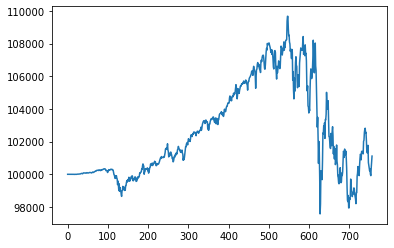

In [170]:
import matplotlib.pyplot as plt
plt.plot(bt.values)

In [171]:
c

,dt,ticker,type,price,shares,amount,cash_left,transaction_cost,pnl
0,2019-09-12,BK,1,42.409199,3,127.227596,99872.517949,0.254455,0.000000
1,2019-09-18,WFC,1,45.201229,3,135.603687,99736.643054,0.271207,0.000000
2,2019-09-20,WFC,0,44.924091,3,134.772274,99871.145783,0.269545,-0.831413
3,2019-09-24,RTX,1,79.142540,3,237.427620,99633.243308,0.474855,0.000000
4,2019-09-25,RTX,0,79.931160,3,239.793480,99872.557201,0.479587,2.365860
...,...,...,...,...,...,...,...,...,...
382,2022-08-25,CL,0,80.919998,3,242.759995,71961.770516,0.485520,12.802528
383,2022-08-30,MRK,1,86.879997,3,260.639992,71700.609244,0.521280,0.000000
384,2022-08-30,V,0,201.380005,6,1208.280029,72906.472713,2.416560,16.535568
385,2022-09-06,TMUS,1,141.910004,3,425.730011,72479.891242,0.851460,0.000000


<AxesSubplot:>

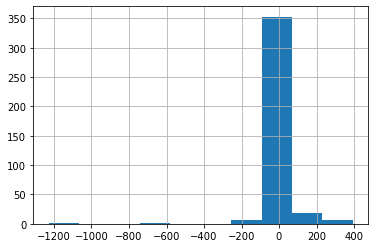

In [175]:
bt.transaction_history['pnl'].hist()

In [173]:
for pos in bt.positions.values():
    pos.show()

Ticker: ABT
Shares: 9
price: 108.4800033569336
Ticker: GS
Shares: 18
price: 340.1000061035156
Ticker: BLK
Shares: 6
price: 695.4600219726562
Ticker: AMZN
Shares: 3
price: 133.27000427246094
Ticker: TXN
Shares: 3
price: 170.74000549316406
Ticker: PFE
Shares: 3
price: 47.84000015258789
Ticker: MA
Shares: 3
price: 335.8500061035156
Ticker: DOW
Shares: 9
price: 50.5099983215332
Ticker: LLY
Shares: 3
price: 317.70001220703125
Ticker: DHR
Shares: 3
price: 290.4200134277344
Ticker: HON
Shares: 6
price: 191.69000244140625
Ticker: WBA
Shares: 6
price: 36.2400016784668
Ticker: T
Shares: 6
price: 17.030000686645508
Ticker: SPG
Shares: 6
price: 103.7699966430664
Ticker: AIG
Shares: 6
price: 55.040000915527344
Ticker: EMR
Shares: 6
price: 84.70999908447266
Ticker: WFC
Shares: 9
price: 45.33000183105469
Ticker: NVDA
Shares: 3
price: 143.8699951171875
Ticker: COF
Shares: 3
price: 108.31999969482422
Ticker: ORCL
Shares: 9
price: 75.91000366210938
Ticker: PYPL
Shares: 3
price: 96.2300033569336
Ticker: 

In [172]:
134.772274-135.603687

-0.8314129999999977